# Time-frequency representations of power
Oscillatory brain activity is modulated in different frequency bands depending on the tasks (Tallon-Baudry and Bertrand 1999). To quantify the frequency specific modulations, time-frequency representations (TFRs) of power are calculated per trial which then are averaged. The power is estimated using Fourier transform and a sliding-window approach. The aim of this section is to characterize the modulation of oscillatory activity in response to visual input.

## Preparation

Important the relevant Python modules:

In [1]:
import os.path as op
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import mne
from mne_bids import BIDSPath, read_raw_bids # If you don't have mne_bids installed, comment this line.
#num_cpu = '1' # Set as a string
#os.environ['OMP_NUM_THREADS'] = num_cpu

Set the paths for the data and results. Note that these will depend on your local setup.

### Loading the data - If you have mne_bids installed

In [2]:
subject = '01'
session = '01'
task = 'SpAtt'  # name of the task
run = '12'  # we have two runs for this subject, let's look at run = 1
meg_suffix = 'meg'
epo_suffix = 'epo'

deriv_root = r'C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Analysis'
bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=epo_suffix, datatype='meg',
            root=deriv_root, extension='.fif', check=False)
print(bids_path.basename,bids_path.fpath)

sub-01_ses-01_task-SpAtt_run-12_epo.fif C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Analysis\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-12_epo.fif


Read the trial-based data stored as epochs:

In [3]:
epochs = mne.read_epochs(bids_path.fpath,
                         preload=True,
                         verbose=True)

Reading C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Analysis\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-12_epo.fif ...
    Found the data of interest:
        t =   -2500.00 ...    2000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
143 matching events found
No baseline correction applied
0 projection items activated


### Loading the data - If you don't have mne_bids installed: Uncomment these two cells

In [4]:
# dir_dat = r'C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Analysis'
# fname_epo = op.join(dir_dat, 'sub-01', 'ses-01', 'meg', 'sub-01_ses-01_task-SpAtt_run-12_epo.fif')

In [5]:
# epochs = mne.read_epochs(fname_epo, preload=True, verbose=True)

## Time-frequency analysis of slower frequencies (<30 hz)
From experience we know that oscillations in slower frequency bands such as in the theta, alpha and beta range are fairly narrow-band (ΔF ~ 2 Hz) whereas neuronal activity in the gamma band (60 - 90 hz) is typically more broad-band (ΔF ~ 5-10 hz). For this reason we advise the use different settings for slower and faster frequencies.

We will be making use of the multi-taper technique. It is implemented as a sliding-time window approach where the Fourier transform is used to estimate the spectral power. In the MNE-Python implementation, the Fourier transform is based on a convolution-type approach. For the sliding window, data are 'tapered', i.e. one or more orthogonal tapers are multiplied to the data in the time-window prior to the Fourier-transform (Percival and Walden, 1993). These tapers are derived from discrete prolate spheroidal sequences (DPSS).


Prior to the analysis, there are 3 important parameters to set.

* *freqs*: defines the frequency range over which to perform the analysis; in this case 2 to 30 Hz in 1 Hz steps.
* *n_cycles*: defines the length of the sliding time-window in units of cycles. For instance, for f = 10 Hz a cycle is T = 1/10 Hz = 0.1 s long. We set n_cycles = freqs/2, i.e. for any frequency the time-window is ΔT = 500 ms (e.g. for f = 10 Hz, the variable n_cycles = 5 resulting in a ΔT = 500 ms time-window).
* *time_bandwidth*: (2ΔTΔF) determines the number of DPSS tapers to be used. It is typically an even number and the number of tapers are then N = time_bandwidth - 1. The tapers relates to the temporal (ΔT) and spectral (ΔF) smoothing: N < 2 ΔT ΔF (Percival and Walden, 1993) . In this example we set time_bandwidth = 2.0, i.e. N = 1. This results in a spectral smoothing dF > 1 Hz. As we only use one taper for the slower frequencies the actual spectral smoothing is in fact 3/2 ΔT ~ 3 Hz

To calculate the TFR for all the planar gradiometers for attention left and right condition separately write:

In [6]:
freqs = np.arange(2, 31, 1)
n_cycles = freqs / 2 
time_bandwidth = 2.0

tfr_s_left =  mne.time_frequency.tfr_multitaper(
    epochs['cue_left'], 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'grad',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs = 4,
    verbose=True)

tfr_s_right = mne.time_frequency.tfr_multitaper(
    epochs['cue_right'], 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'grad',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs= 4, 
    verbose=True)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:   22.6s
[Parallel(n_jobs=4)]: Done 204 out of 204 | elapsed:   27.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:   19.8s
[Parallel(n_jobs=4)]: Done 204 out of 204 | elapsed:   25.4s finished


Note that *n_jobs = 4* allow for parallel execution which is more efficient if you have a multicore CPU. 

Use the *plot* function to show the response from a posterior sensor in the interval -0.5 to 1 s with respect to the onset of the gratings.

No baseline correction applied


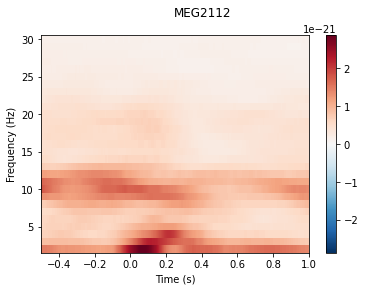

[<Figure size 432x288 with 2 Axes>]

In [7]:
%matplotlib inline
tfr_s_left.plot(
    picks=['MEG2112'], 
    tmin=-0.5, tmax=1.0, 
    title='MEG2112')    

Note the presence of the 10-12 Hz alpha band activty in the interval prior to the onset of the gratings. Also note the power increase at ~0.2 s at 1-5 Hz which likely reflects contributions from the event-relalted field. 
To better observe these effect, one can apply a relative baseline. We have chosen *mode="percent"* as this will 
perform a normalization with respect to the power in the baseline:

$$ P_{relative}(t,f) = {Power(t,f) - Power_{baseline}(f) \over Power_{baseline}(f)} $$

As the sliding time-window is ΔT = 500 ms, we chose a baseline ranging from -500 to -250 ms. This ensures that the baseline is not overlapping with the power-values for t > 0 ms.

Applying baseline correction (mode: percent)


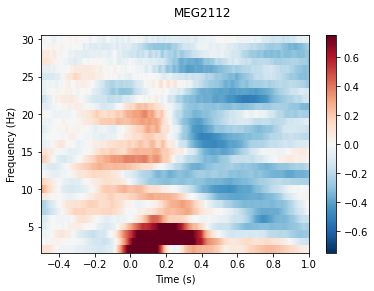

[<Figure size 432x288 with 2 Axes>]

In [8]:
tfr_s_left.plot(
    picks=['MEG2112'], 
    baseline=[-0.500,-0.250], 
    mode="percent", 
    tmin=-0.5, tmax=1,
    title='MEG2112', 
    vmin=-0.75, vmax=0.75)  

The figure above illustrates the modulation of power in response to visual stimulation. Note the typical power decrease after stimulus onset in the 10-12 Hz apha band and also some power decrease at ~20 Hz in the beta band. The effects reflect a decrease in ongoing oscillations with visual input. The early increase at ~5 Hz in theta-band band likely reflects the spectral power of the event-related fields, i.e. it does not reflect a modulation of oscillatory activity *per se*.

**Question 1:**  Plot the results using an absolute baseline. Why is a relative baseline typically used in group studies?

To show the the modulation in power for all sensor arranged topographically write:

Applying baseline correction (mode: percent)


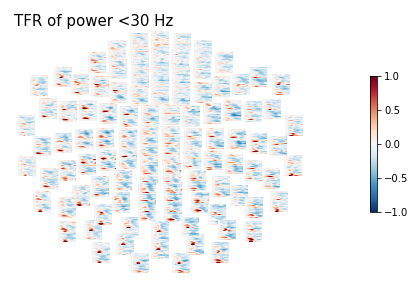

In [9]:
plt = tfr_s_left.plot_topo(
    tmin=-0.5, tmax=1.0, 
    baseline=[-0.5,-0.3], 
    mode="percent", 
    fig_facecolor='w',
    font_color='k',
    vmin=-1, vmax=1,
    title='TFR of power <30 Hz')

To show a topographic map of the alpha depression in the time interval from 300 to 1000 ms use the *plot_topomap* command

Applying baseline correction (mode: percent)


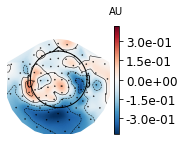

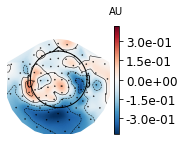

In [10]:
tfr_s_right.plot_topomap(
    tmin=0.35, tmax=1, 
    fmin=9, fmax=11,
    baseline=[-0.5,-0.3], 
    mode="percent")

Note the slight posterior right lateralization of the alpha suppression. This is most likely explained by allocation of attention to the right.

**Question 2**: Repeat the analysis with the 'attend left' trials. Are there any differences from the results of the 'attend left' trials?

**Question 3:**
Change the time-window to 0.25 s and plot the results. What is the main effect in terms of time and frequency smoothing? 

**Question 4:**
Change the time-window to 1.00 s and plot the results. What is the main effect in terms of time and frequency smoothing? 

## Comparing attend right versus attend left

The alpha activty in the cue-stimulus interval is known to be highly modulated by spatial attention. Specifically, numerous studies have demonstrated that posterior alpha power decrease in the hemisphere contralateral to attended direction whereas it increases relatively inthe ipsilateral hemisphere. To identify this effect we will illustrate the alpha modulation in the cue-stimulus interval (-0.5 to 0 s). This will be done by calculating the power lateralization index:

$$ power \: lateralization \: index = {{power_{att,right} - power_{att,left}} \over {power_{att,right} + power_{att,left}}} $$

Note that this measures is calculated without performing baseline correction. 



In [11]:
tfr_s_diff = tfr_s_left.copy();
tfr_s_diff.data = (tfr_s_right.data - tfr_s_left.data)/(tfr_s_right.data + tfr_s_left.data)

To show the *power lateralization index* for all sensors write: 

No baseline correction applied


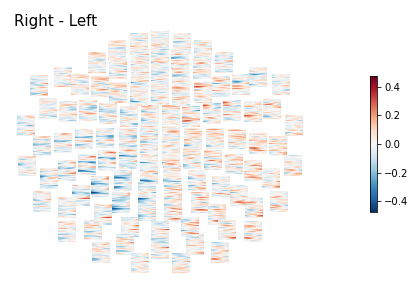

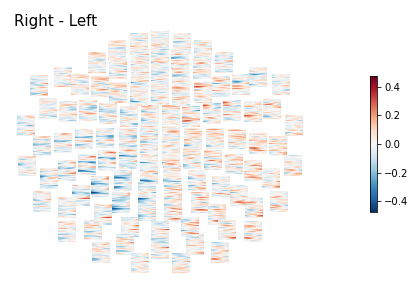

In [12]:
tfr_s_diff.plot_topo(
    tmin=-0.5, tmax=0.0, 
    fig_facecolor='w',
    font_color='k',
    title='Right - Left')

To illustrate the lateralization index for the 10-12 Hz alpha band use the *plot_topomap* function:

No baseline correction applied


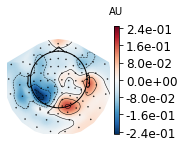

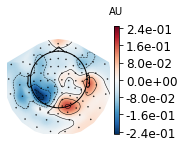

In [13]:
tfr_s_diff.plot_topomap(tmin=-0.5, tmax=0, fmin=10, fmax=12)

## Time-frequency analysis of faster frequencies (>30 hz)

To investigate spectral modulations at fast frequencies, more spectral smoothing is required. This can be achieved by the settings:

* *freqs*: defines the frequency range over which to perform the analysis. We will consider 30 to 100 Hz in steps of 2 Hz.
* *n_cycles*: we set the number of cycles qual to freqs / 4. This results in a time-window dT = 250 ms which is independent of frequency. The relatively short time-window insures good temporal resolution.
* *time_bandwidth* Set the time_bandwith to 4 s. This result in N = 3 tapers. As N < 2 * dT * dF, the resulting spectral smoothing is at least 6 Hz. The relatively large spectral smoothing stems for the empirical observation that visual gamma is somewhat broad-band.

For details on the multitaper approach see see Percival and Walden (1993). 

Apply these settings for the left and right attention condition (note, this step could be quite time-consuming):

In [14]:
freqs = np.arange(30, 101, 2)
n_cycles = freqs / 4 
time_bandwidth = 4.0

tfr_f_left =  mne.time_frequency.tfr_multitaper(
    epochs['cue_left'], 
    freqs=freqs, 
    n_cycles=n_cycles, 
    time_bandwidth=time_bandwidth,
    picks='grad',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs = 4,
    verbose=True)

tfr_f_right = mne.time_frequency.tfr_multitaper(
    epochs['cue_right'],
    freqs=freqs, 
    n_cycles=n_cycles, 
    time_bandwidth=time_bandwidth,
    picks='grad',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs = 4,
    verbose=True)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:   31.0s
[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 204 out of 204 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:   33.5s
[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 204 out of 204 | elapsed:  1.7min finished


Now plot the TFRs of power for a representative posterior sensors using a -0.5 to -0.125 ms baseline. We chose this baseline interval as the lenght of the time window is 250 ms. 

Applying baseline correction (mode: percent)


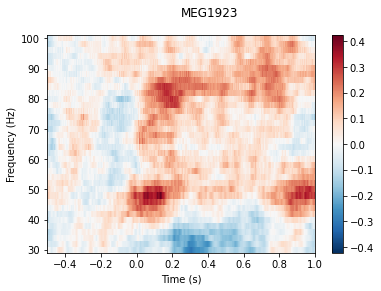

[<Figure size 432x288 with 2 Axes>]

In [15]:
tfr_f_left.plot(
    picks=['MEG1923'], 
    baseline=[-0.5,-0.125], 
    mode="percent", 
    tmin=-0.5, tmax=1,
    title='MEG1923') 

Note the increase in 80-90 Hz gamma power in response to the onset (t = 0 s) of the gratings.

To show the TFRs for all sensors write 

Applying baseline correction (mode: percent)


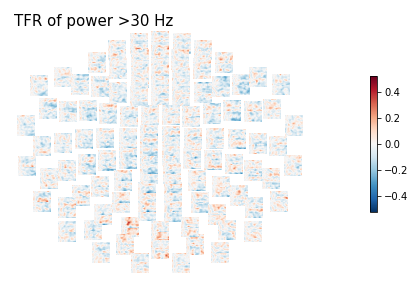

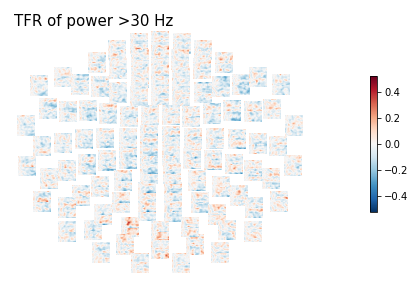

In [16]:
tfr_f_left.plot_topo(
    tmin=-0.5, tmax=1.0, 
    baseline = [-0.5,-0.125], 
    mode="percent", 
    fig_facecolor='w',
    font_color='k', 
    title='TFR of power >30 Hz')

For the topographic representation for gamma activity in response to the gratings write: 

Applying baseline correction (mode: percent)


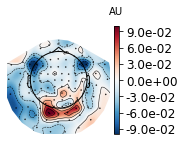

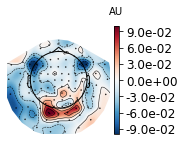

In [17]:
tfr_f_left.plot_topomap(
    tmin=0.0, tmax=0.6, 
    fmin=60, fmax=90, 
    baseline = [-0.5,-0.125], 
    mode="percent", 
    vmin=-0.1, vmax=0.1)

Here appreciate the posterior distribution of the gamma band activity. 

Next, calculate the *power lateralization index* (using the same equations as for the lower frequencies). 


In [18]:
tfr_f_diff = tfr_f_left.copy();
tfr_f_diff.data = (tfr_f_right.data - tfr_f_left.data)/(tfr_f_right.data + tfr_f_left.data)

and display for all sensors:

No baseline correction applied


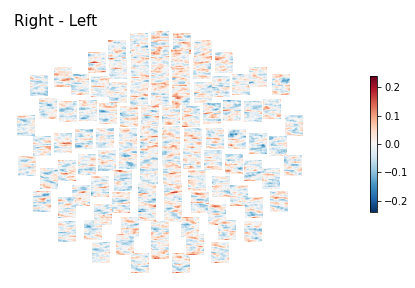

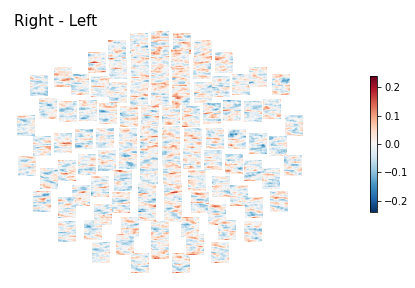

In [19]:
tfr_f_diff.plot_topo(
    tmin=-0.5, tmax=0.0, 
    fig_facecolor='w',
    font_color='k', 
    title='Right - Left')

as well as the topographic plots: 

No baseline correction applied


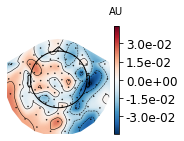

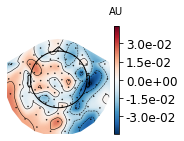

In [20]:
tfr_f_diff.plot_topomap(
    tmin=0.0, tmax=0.6, 
    fmin=60, fmax=90)

**Question 5:** Compare the gamma lateralization to the alppha lateralization. Interpret the alpha and gamma band lateralization in relation to neuronal processing and functional inhibition.

**Question 6:** Change the smoothing to 20 Hz. How many tapers does this result in? What are the consequences for the time-frequency representation?

## Preregistration and publications

It is essential to report all the parameters in the frequency analysis both when submitting a preregistration and a manuscript. Note that the analysis based on a standard spectral analysis and should be independent on the toolbox applied.

Example for text to be used for publications and preregistration:

"The time-frequency representations of power were calculated using a sliding time window approach applied to the single trials (Tallon-Baudry and Bertrand, 1999). For frequencies lower than 30 Hz we used a 500 ms time window. A single discrete prolate spheroidal taper was multiplied to each time window prior to calculating the discrete Fourier transform. This resulted in ±3 Hz spectral smoothing. The power was then estimated as the squared modulus of the Fourier transform. This was done for 1 to 30 Hz in steps of 1 Hz. For frequencies above 30 Hz, a multi-taper method approach (Percival and Walden, 1993) was used involving a sliding time window of 0.25 s. To ensure sufficient spectral smoothing to detect the gamma activity, a set of tapers derived from discrete prolate spheroidal (DPSS), or Slepian sequences, were multiplied to the time-windowed data. We used 3 tapers resulting in a spectral smoothing of ~±8 Hz. Following a discrete Fourier transform the power estimate for the respective tapers were averaged. This was done for 30 to 100 Hz in steps of 2 Hz. The power estimates per trial were subsequently averaged. The relative change in power was then considered with respect to a baseline (-0.5 – -0.25 ms for f < 30 Hz and -0.5 – -0.125 ms for f > 30 Hz). "

## References
* Tallon-Baudry and Bertrand (1999) Oscillatory gamma activity in humans and its role in object representation. Trends Cogn Sci. 3(4):151-162
* Mitra and Pesaran (1999) Analysis of dynamic brain imaging data. Biophys J. 76(2):691-708
* Percival and Walden (1993) Spectral analysis for physical applications: multitaper and conventional univariate techniques. Cambridge, UK
